In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

## simulating an autoregressive moving average process

before jumping into using a dataset, we will create a $ARMA(p,q)$ process, specifically a $ARMA(1,1)$ process defined by the equation:

$y_t = 0.33y_{t–1} + 0.9\epsilon_{t–1} + \epsilon_{t}$

Let's remember that $ARMA(1,1)$ is defined by:

$ARMA(1,1) := y_t = C + \phi_1y_{t-1} + \mu + \theta\epsilon_{t-1}+ \epsilon{t}$

So you might be wondering where is $\mu$ and $C$, well in the first equation they are equal to $0$. So let's not worry about them right now

The purpose of this simulation is to show that we cannot use the old plots we are used to: ACF and PACF, to get $p$ and $q$ anymore

In [5]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

In [6]:
arma_process = sm.tsa.ArmaProcess(ar1, ma1).generate_sample(nsample = 1000)

now that we have our process let's do the steps.

In [7]:
adf = sm.tsa.stattools.adfuller(arma_process)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -6.429878682042654
p-value 1.7078466680100388e-08


since $p < 0.05$ we can reject the null hypothesis and conclude that we have a stationary process.

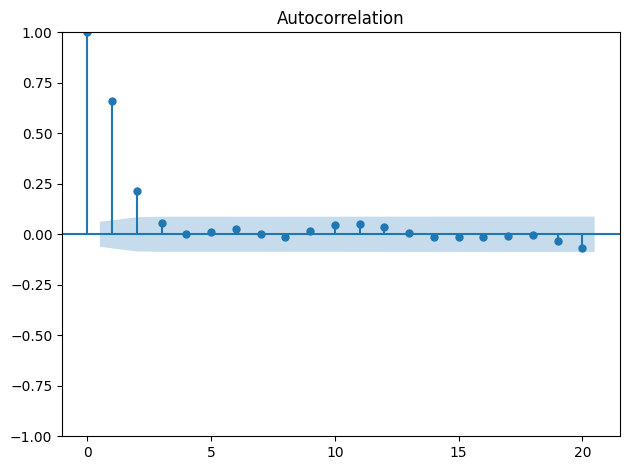

In [8]:
sm.graphics.tsa.plot_acf(arma_process, lags = 20)
plt.tight_layout()

we can see a sinusoidal pattern in the plot, and the last significant lag is 2. Take into account that we did our process specifically to be MA(1) so this plot is not that helpful

/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


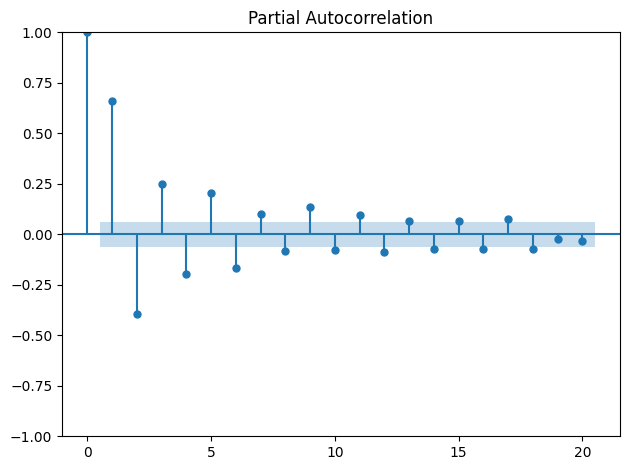

In [9]:
sm.graphics.tsa.plot_pacf(arma_process, lags = 20)
plt.tight_layout()

we see the sinusoidal pattern again so we would not be able to calc $p$ from here

## forecasting bandwidth usage

bandwidth is defined as the max rate of data than can be transfered (bits per second)